## Mini Projeto - Data Science Academy
#### André Campos da Silva
#### 30 de Março, 2021

### Projeto Redefinindo o Tratamento de Câncer

Muito tem sido dito durante os últimos anos sobre como a medicina de
precisão e, mais concretamente, como o teste genético, vai provocar disrupção no
tratamento de doenças como o câncer.

Mas isso ainda está acontecendo apenas parcialmente devido à enorme
quantidade de trabalho manual ainda necessário. Neste projeto, tentaremos levar
a medicina personalizada ao seu potencial máximo.

Uma vez sequenciado, um tumor cancerígeno pode ter milhares de
mutações genéticas. O desafio é distinguir as mutações que contribuem para o
crescimento do tumor das mutações.

Atualmente, esta interpretação de mutações genéticas está sendo feita
manualmente. Esta é uma tarefa muito demorada, onde um patologista clínico tem
que revisar manualmente e classificar cada mutação genética com base em
evidências da literatura clínica baseada em texto.

Para este projeto, o MSKCC (Memorial Sloan Kettering Cancer Center) está
disponibilizando uma base de conhecimento anotada por especialistas, onde
pesquisadores e oncologistas de nível mundial anotaram manualmente milhares
de mutações.

Neste projeto, será desenvolvido um algoritmo de Aprendizado de
Máquina que, usando essa base de conhecimento como uma linha de base,
classifica automaticamente as variações genéticas.

### Descrição de dados

Existem nove classes diferentes nas quais uma mutação genética pode ser classificada.

Esta não é uma tarefa trivial, uma vez que interpretar evidências clínicas é muito desafiador, mesmo para especialistas humanos. Portanto, modelar a evidência clínica (texto) será fundamental para o sucesso de sua abordagem.

Os conjuntos de dados de treinamento e teste são fornecidos por meio de dois arquivos diferentes. Um (training / test_variants) fornece as informações sobre as mutações genéticas, enquanto o outro (training / test_text) fornece a evidência clínica (texto) que nossos especialistas humanos usaram para classificar as mutações genéticas. Ambos estão vinculados por meio do campo ID.

Portanto, a mutação genética (linha) com ID = 15 no arquivo training_variants foi classificada usando a evidência clínica (texto) da linha com ID = 15 no arquivo training_text


### Descrições dos arquivos

training_variants - um arquivo separado por vírgulas contendo a descrição das mutações genéticas usadas para o treinamento. Os campos são ID (o id da linha usada para ligar a mutação à evidência clínica), Gene (o gene onde esta mutação genética está localizada), Variação (a mudança de aminoácido para essas mutações), Classe (1-9 a classe esta mutação genética foi classificada em)

training_text - um arquivo delimitado por pipe duplo (||) que contém a evidência clínica (texto) usada para classificar as mutações genéticas. Os campos são ID (o id da linha usada para vincular a evidência clínica à mutação genética), Texto (a evidência clínica usada para classificar a mutação genética)

test_variants - um arquivo separado por vírgulas contendo a descrição das mutações genéticas usadas para o treinamento. Os campos são ID (o id da linha usada para ligar a mutação à evidência clínica), Gene (o gene onde esta mutação genética está localizada), Variação (a mudança de aminoácido para essas mutações)

test_text - um arquivo delimitado por pipe duplo (||) que contém a evidência clínica (texto) usada para classificar as mutações genéticas. Os campos são ID (o id da linha usada para vincular a evidência clínica à mutação genética), Texto (a evidência clínica usada para classificar a mutação genética)


## Carregando pacotes


In [1]:
# Pacotes usados no projeto
import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,RFE,mutual_info_classif,f_classif
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,KFold
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier,VotingClassifier,RandomForestClassifier,ExtraTreesClassifier,StackingClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
from keras.models import model_from_json
import os

## Carregando os Dados

In [2]:
# Carregos os dados de treino. 
df_train = pd.read_csv('Dados/training_variants') 
train_text = pd.read_csv('Dados/training_text', sep="\|\|",names=["ID","Text"],skiprows=1)

In [3]:
df_train.head(10)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [4]:
train_text.head(10)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...
6,6,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL is a negative regulator of activated recep...
8,8,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,Abstract Juvenile myelomonocytic leukemia (JM...


## Análise Exploratória

In [5]:
# Verifico o shape

print(f' Shape df_train = {df_train.shape} \n Shape train_text = {train_text.shape}')

 Shape df_train = (3321, 4) 
 Shape train_text = (3321, 2)


In [6]:
# Verifico o tipo de cada variável

print(f' Dtype df_train \n{df_train.dtypes} \n\n Dtype train_text \n{train_text.dtypes}')

 Dtype df_train 
ID            int64
Gene         object
Variation    object
Class         int64
dtype: object 

 Dtype train_text 
ID       int64
Text    object
dtype: object


In [7]:
# valores Nulos
print(f'df_train \n{df_train.isna().sum()}\n')
print(f'train_text \n{train_text.isna().sum()}')

df_train 
ID           0
Gene         0
Variation    0
Class        0
dtype: int64

train_text 
ID      0
Text    5
dtype: int64


In [8]:
# Valores Únicos
print(f'df_train \n{df_train.nunique()}\n')
print(f'train_text \n{train_text.nunique()}')

df_train 
ID           3321
Gene          264
Variation    2996
Class           9
dtype: int64

train_text 
ID      3321
Text    1920
dtype: int64


In [9]:
# Crio uma função para um grafico de barras.

def barPlot(data, col1, col2, title, cor):
   sns.set(style="darkgrid")
   sns.barplot(x = col1,y = col2, data=data, color=cor)
   plt.title(title, fontsize=18,color="black",alpha=2)
   plt.xlabel(col1, size = 12,color="black")
   plt.ylabel(col2, size = 12,color="black")
   sns.despine(left=True, bottom=True)
   plt.show()

# Crio uma função para um grafico de contagem.
def barPlotHue(data, x, y, hue,title):
   sns.set(style="darkgrid")
   sns.barplot(x=x, y=y, hue=hue, data=data)
   plt.title(title)
   plt.xlabel(x) 
   plt.ylabel(y)
   plt.show()

In [10]:
# Quantidade para cada Gene
gene = df_train.groupby('Gene').size().sort_values(ascending = False)
gene

Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
PAK1        1
FAM58A      1
FANCC       1
FGF19       1
KLF4        1
Length: 264, dtype: int64

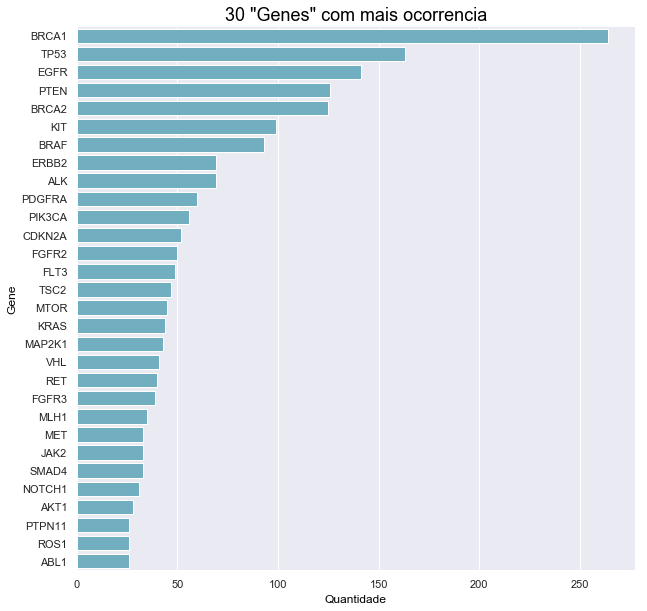

In [11]:
# Plot das 30 com mais quantidade

# Crio um Data frame com os 30 genes com maiores ocorrências  
gene = df_train.groupby('Gene').size().sort_values(ascending = False)
gene = pd.DataFrame(gene.reset_index().head(30))
gene.columns =['Gene', 'Quantidade']
# Dimensão do plot
plt.figure(figsize = (10,10))
barPlot(gene,'Quantidade','Gene','30 "Genes" com mais ocorrencia','c')

o gene (BRCA1) é o gene com maior quantidade, bem superior aos demais, em comparação com o segundo maior (TP53) ele possui quase odobro de ocorrências.

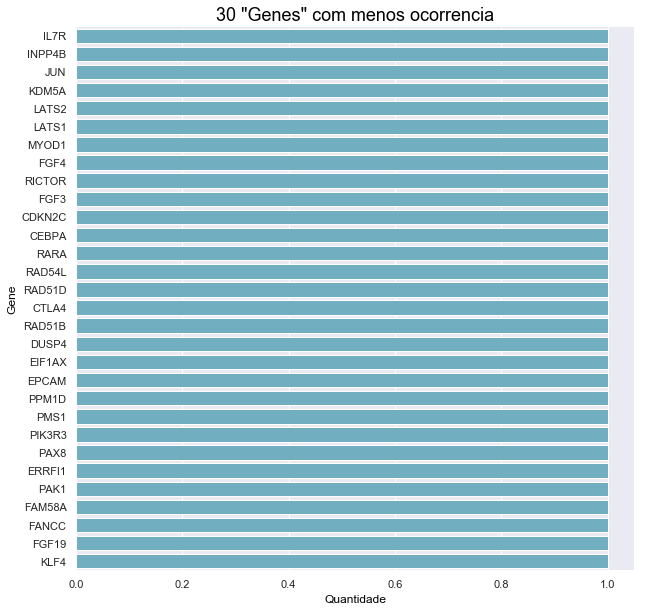

In [12]:
# Plot das 30 com menos quantidade

# Crio um Data frame com os 30 genes com menores ocorrências 
gene = df_train.groupby('Gene').size().sort_values(ascending = False)
gene = pd.DataFrame(gene.reset_index().tail(30))
gene.columns =['Gene', 'Quantidade']
# Dimensão do plot
plt.figure(figsize = (10,10))
barPlot(gene,'Quantidade','Gene','30 "Genes" com menos ocorrencia','c')

Já para os Genes com menos frequência temos os 30 últimos apenas com 1 ocorrência, 

In [13]:
# Quantidade para cada Variation
variation = df_train.groupby('Variation').size().sort_values(ascending = False)
variation

Variation
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
                        ..
R134Q                    1
R1343L                   1
R133H                    1
R133*                    1
1_2009trunc              1
Length: 2996, dtype: int64

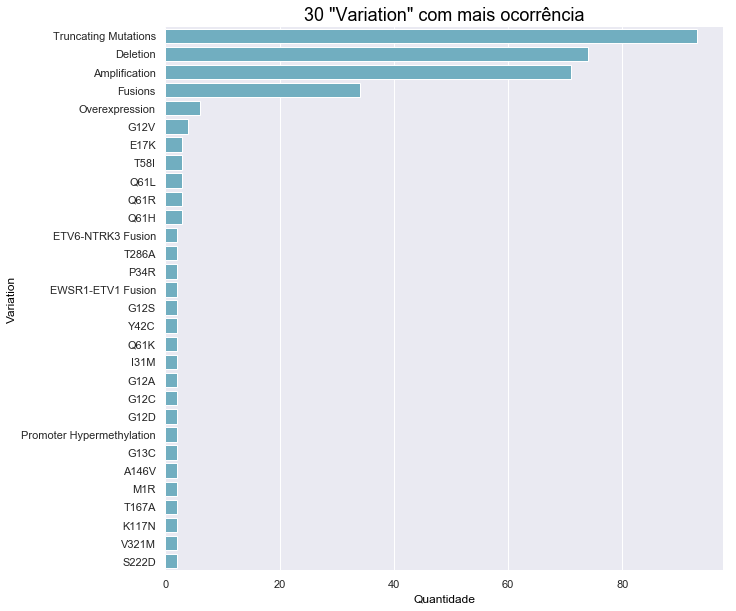

In [14]:
# Plot dos 30 com mais quantidade

# Crio um Data frame com os 3 Variation com maiores ocorrências   
variation = df_train.groupby('Variation').size().sort_values(ascending = False)
variation = pd.DataFrame(variation.reset_index().head(30))
variation.columns =['Variation', 'Quantidade']
# Dimensão do plot
plt.figure(figsize = (10,10))
barPlot(variation,'Quantidade','Variation','30 "Variation" com mais ocorrência','c')

Variações do tipo Truncating Mutations, Deletion e Amplification são as mais predominantes 


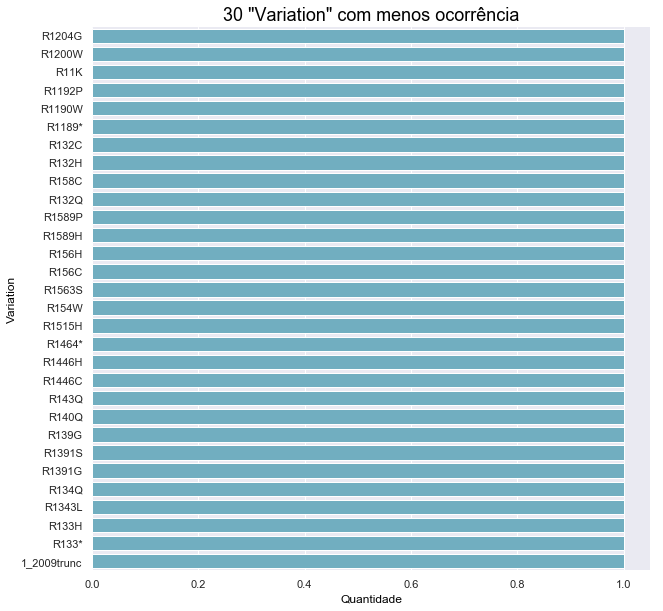

In [15]:
# Plot dos 30 com menos quantidade

# Crio um Data frame com os 30 Variation com menores ocorrências 
variation = df_train.groupby('Variation').size().sort_values(ascending = False)
variation = pd.DataFrame(variation.reset_index().tail(30))
variation.columns =['Variation', 'Quantidade']
# Dimensão do plot
plt.figure(figsize = (10,10))
barPlot(variation,'Quantidade','Variation','30 "Variation" com menos ocorrência','c')

Assim como Gene, as 30 com menores ocorrências não passam de 1

In [16]:
# Quantidade de valores para cada Class target.

# Crio um Data frame 
Class = df_train.groupby('Class').size().sort_values(ascending = False)
Class = pd.DataFrame(Class.reset_index())
Class.columns =['Class', 'Quantidade']
Class

,Class,Quantidade
0,7,953
1,4,686
2,1,568
3,2,452
4,6,275
5,5,242
6,3,89
7,9,37
8,8,19


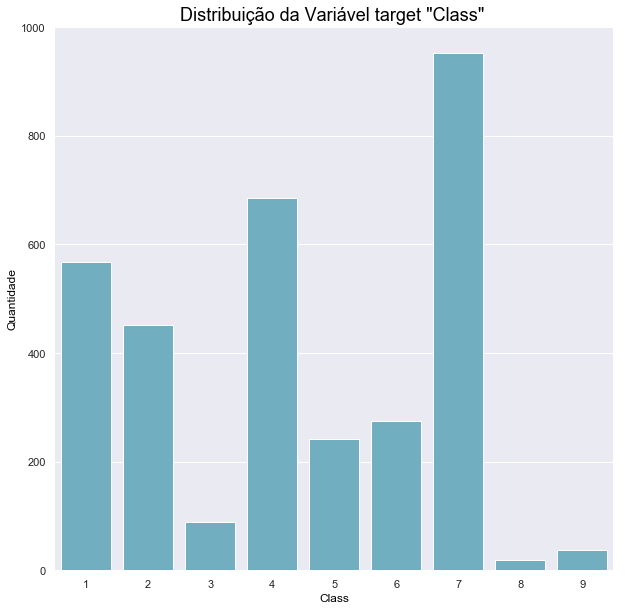

In [17]:
# Plot da variável target

# Crio um Data frame 
Class = df_train.groupby('Class').size().sort_values(ascending = False)
Class = pd.DataFrame(Class.reset_index())
Class.columns =['Class', 'Quantidade']
# Dimensão do plot
plt.figure(figsize = (10,10))
barPlot(Class,'Class','Quantidade','Distribuição da Variável target "Class" ','c')

Os maiores casos se concentram nas classes, 1,2,4 e principalmente na 7.

In [18]:
# Top 10 Genes com mais ocorrencia separando por classe
# Crio um Data Frame
gene = df_train.groupby(['Class','Gene']).size().sort_values(ascending = False)
gene = pd.DataFrame(gene.reset_index().head(16))
gene.columns =['Class','Gene', 'Quantidade']
gene

,Class,Gene,Quantidade
0,4,PTEN,115
1,5,BRCA1,90
2,6,BRCA2,84
3,7,EGFR,84
4,1,TP53,83
5,4,TP53,67
6,1,BRCA1,60
7,6,BRCA1,53
8,7,KIT,52
9,7,BRAF,48


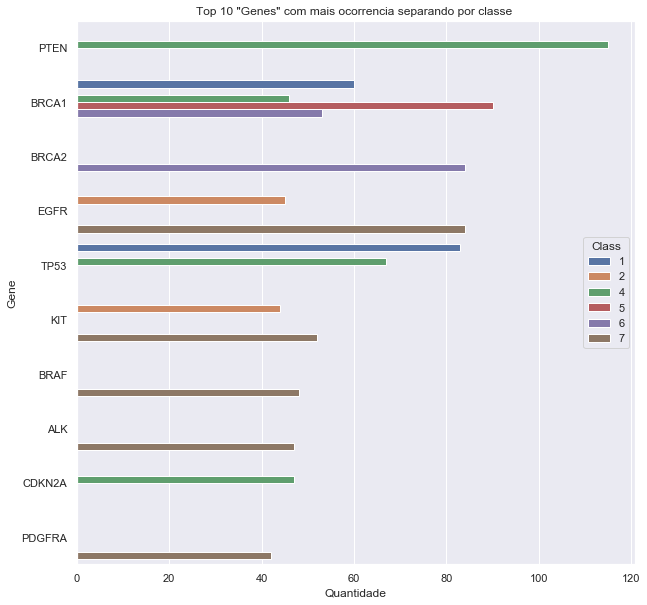

In [19]:
# Top 10 Genes com mais ocorrencia separando por classe
# Crio um Data Frame
gene = df_train.groupby(['Class','Gene']).size().sort_values(ascending = False)
gene = pd.DataFrame(gene.reset_index().head(16))
gene.columns =['Class','Gene', 'Quantidade']

# Dimensão do plot
plt.figure(figsize = (10,10))
barPlotHue(gene,"Quantidade", "Gene",'Class', 'Top 10 "Genes" com mais ocorrencia separando por classe ')


As classes 3,8 e 9 nem aparecem no top 10 dos genes agrupando por classe. 

Pode-se notar também uma maior quantidade entre as classes dos Genes ( BRCA1,TP53, EGFR) uma vez que são as com maiores quantidades como foi visto no gráfico de Gene acima. 


In [20]:
# Top 10 Genes com menos ocorrencia separando por classe
# Crio um Data Frame
gene = df_train.groupby(['Class','Gene']).size().sort_values(ascending = False)
gene = pd.DataFrame(gene.reset_index().tail(10))
gene.columns =['Class','Gene', 'Quantidade']
gene

,Class,Gene,Quantidade
580,6,EGFR,1
581,2,MYCN,1
582,5,ERCC2,1
583,2,MYOD1,1
584,7,MDM4,1
585,7,MDM2,1
586,2,NOTCH2,1
587,5,FGFR1,1
588,2,NTRK2,1
589,6,BRIP1,1


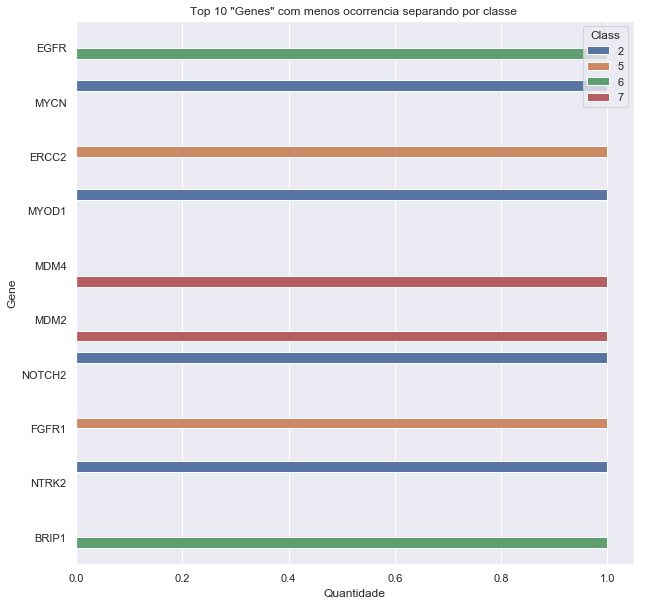

In [21]:
# Top 10 Genes com menos ocorrencia separando por classe
# Crio um Data Frame
gene = df_train.groupby(['Class','Gene']).size().sort_values(ascending = False)
gene = pd.DataFrame(gene.reset_index().tail(10))
gene.columns =['Class','Gene', 'Quantidade']

# Dimensão do plot
plt.figure(figsize = (10,10))
barPlotHue(gene,"Quantidade", "Gene",'Class', 'Top 10 "Genes" com menos ocorrencia separando por classe ')

A distribuição top 10 de Gene com menos frequência estão classes 2 ,5,6, 7. 

In [22]:
# Top 10 Variation com mais ocorrencia separando por classe
# Crio um Data Frame
variation = df_train.groupby(['Class','Variation']).size().sort_values(ascending = False)
variation = pd.DataFrame(variation.reset_index().head(13))
variation.columns =['Class','Variation', 'Quantidade']
variation

,Class,Variation,Quantidade
0,1,Truncating Mutations,89
1,1,Deletion,57
2,7,Amplification,40
3,2,Fusions,31
4,2,Amplification,21
5,4,Deletion,16
6,6,Amplification,10
7,7,G12V,4
8,7,Overexpression,4
9,7,Q61L,3


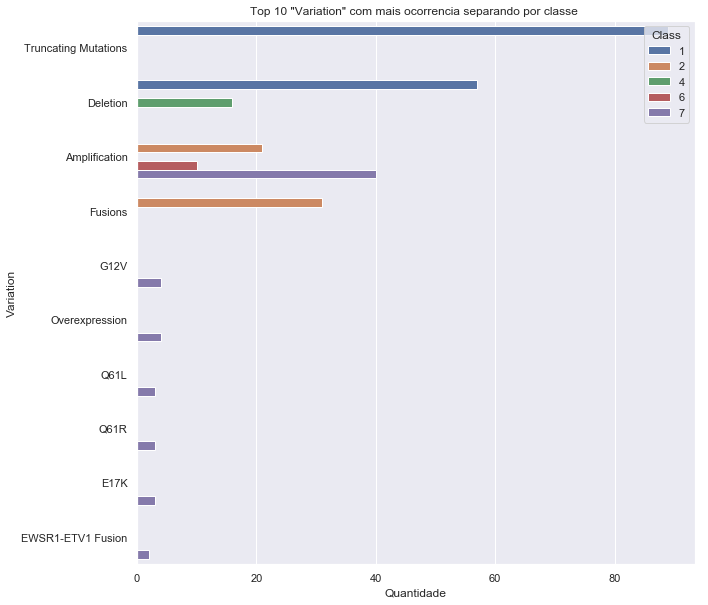

In [23]:
# Top 10 Variation com mais ocorrencia separando por classe
# Crio um Data Frame
variation = df_train.groupby(['Class','Variation']).size().sort_values(ascending = False)
variation = pd.DataFrame(variation.reset_index().head(13))
variation.columns =['Class','Variation', 'Quantidade']

# Dimensão do plot
plt.figure(figsize = (10,10))
barPlotHue(variation,"Quantidade", "Variation",'Class', 'Top 10 "Variation" com mais ocorrencia separando por classe ')


Como vimos as 3 Variation/classe com mais casos também são as que vimos no gráfico de Variation. 
A classe 7 por te maiores volumes de casos aparecem com mais frequência.


In [24]:
# Top 10 Variation com menos ocorrencia separando por classe
# Crio um Data Frame
variation = df_train.groupby(['Class','Variation']).size().sort_values(ascending = False)
variation = pd.DataFrame(variation.reset_index().tail(10))
variation.columns =['Class','Variation', 'Quantidade']
variation

,Class,Variation,Quantidade
3022,6,R725C,1
3023,6,R71G,1
3024,6,R683T,1
3025,6,R669C,1
3026,6,R661W,1
3027,6,R659P,1
3028,6,R561C,1
3029,6,R498L,1
3030,6,R428A,1
3031,1,1_2009trunc,1


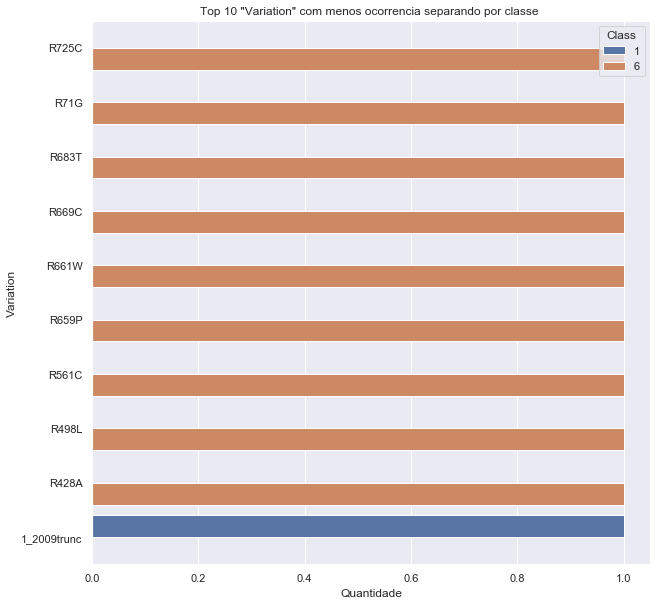

In [25]:
# Top 10 Variation com menos ocorrencia separando por classe
# Crio um Data Frame
variation = df_train.groupby(['Class','Variation']).size().sort_values(ascending = False)
variation = pd.DataFrame(variation.reset_index().tail(10))
variation.columns =['Class','Variation', 'Quantidade']
variation

# Dimensão do plot
plt.figure(figsize = (10,10))
barPlotHue(variation,"Quantidade", "Variation",'Class', 'Top 10 "Variation" com menos ocorrencia separando por classe ')

Temos a classe 6 predominante para os 10 variation/classe com menos frequência. 

## Tratamento dos dados


Irei preparar cada DataFrame separadamente, primeiro realizando o dummy para as variáveis do df_train e depois o tratamento do texto do train_text e então fazer um join entre os dois pelo ID para passar para os modelos preditivos.  

Para o df_train eu vou aplicar duas técnicas, a primeira será criar as variáveis dummy para cada variável categórica, e a segunda tecnica sera ao invés de criar as dummies eu ire fazer o label encoder de cada variável. 
Com isso terei dois DataFrame para treinar os modelos e ver qual tem a melhor performance. 


In [26]:
# Crio o primeiro DataFrame com a tecnica 1 - criação das dummies

# Faço uma copia do df_train para usar no tratamento
df_train_dummy = df_train.copy()

# Crio as variáveis Dummy
gene_dummies = pd.get_dummies(df_train_dummy['Gene'])
variation_dummies = pd.get_dummies(df_train_dummy['Variation'])

# Uso o concat para trazer as dummies para o DataFrane
variation_dummies = pd.concat([df_train_dummy,gene_dummies,variation_dummies],axis=1)

# Retiro as variáveis categoricas em string.
variation_dummies.drop(['Gene','Variation'], axis=1, inplace=True)

# Imprimo o resultado em 5 primeiras linhas.
variation_dummies.head()

,ID,Class,ABL1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALK,APC,...,Y87N,Y901C,Y931C,Y98H,Y98N,YAP1-FAM118B Fusion,YAP1-MAMLD1 Fusion,ZC3H7B-BCOR Fusion,ZNF198-FGFR1 Fusion,p61BRAF
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Crio o primeiro DataFrame com a tecnica 2 - criação dos labels.

# Faço uma copia do df_train para usar no tratamento
df_train_label = df_train.copy()

# Crio o algoritmo para cada variável
lb_Gene = LabelEncoder()
lb_Variation  = LabelEncoder()

# Label para a variável Gene
lb_Gene.fit(df_train_label['Gene'])
df_train_label['Gene'] = lb_Gene.transform(df_train_label['Gene'])

# Label para a variável Variation
lb_Variation.fit(df_train_label['Variation'])
df_train_label['Variation'] = lb_Variation.transform(df_train_label['Variation'])

# Imprimo o resultado em 5 primeiras linhas.
df_train_label.head()

,ID,Gene,Variation,Class
0,0,85,2629,1
1,1,39,2856,2
2,2,39,1897,2
3,3,39,1667,3
4,4,39,1447,4


In [28]:
# Agora começo a parte de pré processamento do train_text

#Crio a formula para fazer o pré processamento. 
def text_preprocess(text):
    
    # Crio uma copia do DataFrame
    train_text_clear = text.copy()
    
    # Como vi anteriomente temos 5 linhas com valires NaN, irei remove-las antes do tratamento.
    train_text_clear.dropna(axis=0, how='any', inplace=True)

    # Retiro pontuação e caracteres e numeros
    train_text_clear['Text'] = train_text_clear["Text"].str.replace("[^a-zA-Z0-9\n]"," ")
    train_text_clear['Text'] = train_text_clear["Text"].str.replace("[$\d+\W+|\b\d+\b|\W+\d+$]"," ")
    
    # Converto to para lower()
    train_text_clear["Text"] = [i.lower() for i in train_text_clear["Text"]]

    # Faço a tokenização
    train_text_clear['Text'] = [word_tokenize(i) for i in train_text_clear['Text']]

    #Retido as stop words
    english_stops = set(stopwords.words('english'))
    train_text_clear['Text'] = train_text_clear['Text'].apply(lambda x: [i for i in x if i not in english_stops])

    # Faço o Stemming das palavras
    porter_stemmer = PorterStemmer()
    train_text_clear['Text'] = train_text_clear['Text'].apply(lambda x: [porter_stemmer.stem(i) for i in x])
    
    # Faço o join do texto.
    train_text_clear['Text']=[" ".join(i) for i in train_text_clear['Text']]

    return train_text_clear
    

In [29]:
# Formula para a vetorização do texto. 
def textvec(text):
    
    #Faco uma copia do DataFrame limpo.
    text2 = text.copy()
       
    # Crio o algoritmo para a vetorização com no max 2000 variáveis.
    vectorizer = TfidfVectorizer(stop_words = 'english',max_features = 2000)
    
    # Rodo ja criando uma lista e convertendo para array
    textVec = list(vectorizer.fit_transform(text2['Text'].values).toarray())
    
    # Converto o array em um DataFrame do pandas. 
    textVec = pd.DataFrame(textVec)
    
    # retorno o resultado
    return textVec
    

In [30]:
# Faço o pré processamento gerando um DataFrame novo ja com o texto tratado. 
train_text_clear = text_preprocess(train_text)

# Imprimo as 5 primeiras linhas
train_text_clear.head(5)

,ID,Text
0,0,cyclin depend kinas cdk regul varieti fundamen...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evid demonstr acquir uniparent disomi a...
4,4,oncogen mutat monomer casita b lineag lymphoma...


#### Tecnica 1 (Dummy + Vexto Vetorizado  = PCA)

Para essa primeira técnica eu irei juntar o DataFrame gerado com as variáveis e o DataFrame gerado com as variáveis vetorizadas através da variável ID, como terá uma grande quantidade de variável eu irei aplicar a técnica do PCA para redução da Dimensionalidade para depois apresentar para os algoritmos. 

In [31]:
# Crio as variáveis com a formula de vetorização. 
textVec = textvec(train_text_clear)

# Crio um novo DataFrame junto as variaveis vetorizadas ao DataFrame com o ID
trainvec = train_text_clear.reset_index().join(textVec)

# Recoloco o index que foi resetado para o join anterior
trainvec = trainvec.set_index('index')

# Removo a variável Text que não será mais necessária.
trainvec = trainvec.drop(columns =['Text'])

# Ja verifico se gerou algum valor nulo, se tiver é porque algo deu errado. 
trainvec[trainvec.isnull().any(axis=1,)]

,ID,0,1,2,3,4,5,6,7,8,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
index,,,,,,,,,,,,,,,,,,,,,


In [32]:
# Imprimo as 10 primeiras linhas 
trainvec.head(10)

,ID,0,1,2,3,4,5,6,7,8,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
index,,,,,,,,,,,,,,,,,,,,,
0,0,0.0,0.000000,0.004637,0.005629,0.000000,0.002172,0.000000,0.005904,0.003531,...,0.0,0.000000,0.0,0.0,0.000000,0.015486,0.000000,0.000000,0.0,0.000000
1,1,0.0,0.000000,0.000000,0.000000,0.007058,0.000000,0.003885,0.000000,0.000000,...,0.0,0.007357,0.0,0.0,0.006441,0.000000,0.003178,0.000000,0.0,0.000000
2,2,0.0,0.000000,0.000000,0.000000,0.007058,0.000000,0.003885,0.000000,0.000000,...,0.0,0.007357,0.0,0.0,0.006441,0.000000,0.003178,0.000000,0.0,0.000000
3,3,0.0,0.000000,0.000000,0.006770,0.005088,0.002612,0.014004,0.042610,0.004248,...,0.0,0.000000,0.0,0.0,0.006191,0.000000,0.000000,0.000000,0.0,0.000000
4,4,0.0,0.000000,0.003576,0.000000,0.000000,0.003349,0.000000,0.000000,0.010893,...,0.0,0.000000,0.0,0.0,0.001984,0.000000,0.000000,0.000000,0.0,0.050476
5,5,0.0,0.000000,0.003576,0.000000,0.000000,0.003349,0.000000,0.000000,0.010893,...,0.0,0.000000,0.0,0.0,0.001984,0.000000,0.000000,0.000000,0.0,0.050476
6,6,0.0,0.000000,0.003576,0.000000,0.000000,0.003349,0.000000,0.000000,0.010893,...,0.0,0.000000,0.0,0.0,0.001984,0.000000,0.000000,0.000000,0.0,0.050476
7,7,0.0,0.026702,0.000000,0.030430,0.000000,0.000000,0.004896,0.007093,0.000000,...,0.0,0.000000,0.0,0.0,0.002319,0.000000,0.001144,0.002856,0.0,0.000000
8,8,0.0,0.000000,0.001431,0.001737,0.000000,0.001340,0.001437,0.000000,0.013074,...,0.0,0.001360,0.0,0.0,0.000794,0.000000,0.000000,0.000000,0.0,0.020195


In [33]:
# DataFrame tecnica 1 com as variáveis Dummies

# Faço o Join pela variável ID
trainD = pd.merge(variation_dummies,trainvec,how='left', on='ID')

# Verifico se gerou algum valor nulo, 
trainD[trainD.isnull().any(axis=1,)]



,ID,Class,ABL1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALK,APC,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
1109,1109,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1277,1277,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1407,1407,6,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1639,1639,6,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2755,2755,7,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Fazendo uma análise verifiquei que esses ID não tem no DataFrame de texto, por isso que gerou os dados NaN, como são apenas 5 opto em remove-los.
trainD.dropna(axis=0, inplace=True)

# Verifico novamente.  
trainD[trainD.isnull().any(axis=1,)]



,ID,Class,ABL1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALK,APC,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999


In [35]:
trainD.head(5)

,ID,Class,ABL1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALK,APC,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.015486,0.000000,0.0,0.0,0.000000
1,1,2,0,0,0,0,0,0,0,0,...,0.0,0.007357,0.0,0.0,0.006441,0.000000,0.003178,0.0,0.0,0.000000
2,2,2,0,0,0,0,0,0,0,0,...,0.0,0.007357,0.0,0.0,0.006441,0.000000,0.003178,0.0,0.0,0.000000
3,3,3,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.006191,0.000000,0.000000,0.0,0.0,0.000000
4,4,4,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.001984,0.000000,0.000000,0.0,0.0,0.050476


In [36]:
# Salvo DataFrame para a técnica 2 pronto para não precisa reprocessar tudo novamente se necessário.
trainD.to_csv('Dados/trainD.csv',encoding="utf-8", index=None)

In [37]:
# Carrego os dados caso for iniciar a partir daqui. Descomente a linha. 
#trainD = pd.read_csv('Dados/trainD.csv',encoding="utf-8")

In [38]:
# Agora para finalizar a dados para a tecnica 1 ire realizar o PCA das variáveis diminuindo para 100. 

# Retiro a variável target (Class) 
trainD_Y = trainD['Class'].values

# Removo a variável ID e a Class deixando apenas as variáveis preditoras.
trainD2 = trainD.drop(columns =['ID'])
trainD2 = trainD2.drop(columns =['Class'])

# Crio o PCA para reduzir a dimensionalidade para 100 variáveis
pca = PCA(n_components=100)
pca_fit_D = pca.fit(trainD2)
trainD_X = pca_fit_D.transform(trainD2)

In [39]:
trainD_X.shape

(3316, 100)

In [40]:
trainD_X

array([[-0.12679981, -0.04044115, -0.12261834, ..., -0.01257108,
         0.01613823, -0.00608702],
       [-0.11741177,  0.05832492,  0.00430834, ...,  0.01122776,
         0.00607107,  0.00053494],
       [-0.11741177,  0.05832492,  0.00430834, ...,  0.01122776,
         0.00607107,  0.00053494],
       ...,
       [-0.10431858, -0.02486963, -0.0765701 , ..., -0.0322113 ,
        -0.02457966,  0.02561181],
       [-0.10277667, -0.01371235, -0.05371175, ..., -0.0358221 ,
        -0.00716667,  0.01099653],
       [-0.09857974, -0.01790164, -0.0585671 , ..., -0.02717561,
        -0.00795019,  0.01627921]])

In [41]:
trainD_Y

array([1, 2, 2, ..., 1, 4, 4], dtype=int64)

In [42]:
trainD_Y.shape

(3316,)

### Balanceamento das classes tecnica - 1

Como temos poucos dados e variáveis desbalanceadas como visto na análise exploratória, vou usar o pacote Smote para tenta balancear um pouco melhor e também aumentar um pouco a quantidade de dados para treino. 

In [43]:
# Crio o algoritmo e realizo o baanceamento das classes 
smote = SMOTE()
trainD_X, trainD_Y = smote.fit_resample(trainD_X, trainD_Y)

In [44]:
# Shape das variáveis preditoras após o smote
trainD_X.shape

(8568, 100)

In [45]:
# Shape das variáveis target após o smote
trainD_Y.shape

(8568,)

In [46]:
# Distribuição após o smote
pd.DataFrame(trainD_Y).value_counts()

9    952
8    952
7    952
6    952
5    952
4    952
3    952
2    952
1    952
dtype: int64

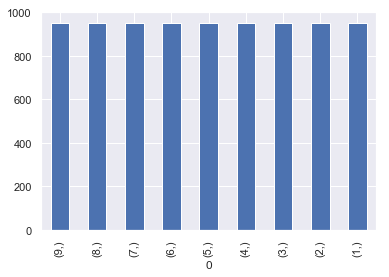

In [47]:
# Distribuição após o smote ( Grafico de barras)
pd.DataFrame(trainD_Y).value_counts().plot(kind='bar')

Com isso finalizo as variáveis X e Y para a técnica 1, agora irei criar outras variáveis X e Y utilizando a técnica 2 para depois iniciar o processo de predição. 

In [48]:
# DataFrame tecnica 2 com as variáveis com o LabelEncoder

#faço uma copia do trainvec.
trainvec_PCA = trainvec.copy()

# Faço um backup do ID do trainvec
trainvec_ID = trainvec["ID"]

# Removo a variável ID que não será mais necessária.
trainvec_PCA = trainvec.drop(columns =['ID'])

# Crio o PCA para reduzir a dimensionalidade das variáveis trainvec para essa tecnica antes de fazer o join.
pca = PCA(n_components=60)
pca_fit_L = pca.fit(trainvec_PCA)
trainvec_PCA = pca_fit_L.transform(trainvec_PCA)


# Converto  para Data Frame
trainvec_PCA = pd.DataFrame(trainvec_PCA)

# Crio um novo DataFrame juntando as variaveis do PCA com o ID.
trainvec_PCA = trainvec_ID.reset_index().join(trainvec_PCA)
trainvec_PCA = trainvec_PCA.set_index('index')

# Verifico se foi gerado algum valor nulo
trainvec_PCA[trainvec_PCA.isnull().any(axis=1)]


,ID,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
index,,,,,,,,,,,,,,,,,,,,,


In [49]:
trainvec_PCA.head(10)

,ID,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
index,,,,,,,,,,,,,,,,,,,,,
0,0,-0.088056,0.018124,-0.155402,-0.061555,-0.080899,0.006825,0.052231,-0.040693,0.102675,...,0.016866,-0.030232,-0.022186,-0.019856,0.035166,0.017454,0.009237,-0.035501,0.014827,-0.013996
1,1,-0.094138,-0.075488,0.045001,0.083947,0.001516,0.025815,0.052452,-0.002954,0.028078,...,0.046131,0.024696,-0.030937,0.001910,-0.003113,-0.029328,-0.012045,0.011752,-0.005163,-0.008343
2,2,-0.094138,-0.075488,0.045001,0.083947,0.001516,0.025815,0.052452,-0.002954,0.028078,...,0.046131,0.024696,-0.030937,0.001910,-0.003113,-0.029328,-0.012045,0.011752,-0.005163,-0.008343
3,3,-0.079622,-0.037707,-0.002492,0.040503,-0.000575,-0.044254,-0.021092,-0.044732,0.021832,...,0.017099,0.012098,-0.017094,0.006035,0.005610,-0.027718,-0.004538,0.004798,0.002591,0.001227
4,4,-0.059729,-0.013855,0.015552,0.042018,-0.010931,0.029312,0.035422,-0.041151,0.010509,...,0.040589,0.014347,-0.006936,0.002273,-0.014620,-0.011004,0.002019,-0.013146,0.003238,0.011268
5,5,-0.059729,-0.013855,0.015552,0.042018,-0.010931,0.029312,0.035422,-0.041151,0.010509,...,0.040589,0.014347,-0.006936,0.002273,-0.014620,-0.011004,0.002019,-0.013146,0.003238,0.011268
6,6,-0.059729,-0.013855,0.015552,0.042018,-0.010931,0.029312,0.035422,-0.041151,0.010509,...,0.040589,0.014347,-0.006936,0.002273,-0.014620,-0.011004,0.002019,-0.013146,0.003238,0.011268
7,7,-0.092313,-0.033012,-0.057288,0.075428,-0.003454,-0.059039,-0.024487,-0.008053,0.043979,...,0.022198,0.024141,-0.009807,-0.021783,-0.013416,-0.022655,0.004506,-0.009982,0.007678,0.015445
8,8,-0.078133,-0.003370,-0.063948,0.053176,-0.011869,-0.002153,0.020002,0.006790,0.025589,...,0.029261,0.020660,-0.014244,-0.013787,0.000186,-0.017396,0.003952,-0.003632,0.009268,0.002636


In [50]:
# Faço o Join pela variável ID
trainL = pd.merge(df_train_label,trainvec_PCA,how='left', on='ID')

# Removo a variável Text que não será mais necessária.
trainL = trainL.drop(columns =['ID'])

# Verifico se gerou algum valor nulo, 
trainL[trainL.isnull().any(axis=1,)] 


,Gene,Variation,Class,0,1,2,3,4,5,6,...,50,51,52,53,54,55,56,57,58,59
1109,86,2296,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1277,13,2629,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1407,95,1270,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1639,97,149,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2755,30,958,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Fazendo uma análise verificamos que esses ID não tem no DataFrame de texto, por isso que gerou os dados NaN, como são apenas 5 opto em remove-los.
trainL.dropna(axis=0, inplace=True)

# Verifico novamente.  
trainL[trainL.isnull().any(axis=1,)]

,Gene,Variation,Class,0,1,2,3,4,5,6,...,50,51,52,53,54,55,56,57,58,59


In [52]:
trainL.head(10)

,Gene,Variation,Class,0,1,2,3,4,5,6,...,50,51,52,53,54,55,56,57,58,59
0,85,2629,1,-0.088056,0.018124,-0.155402,-0.061555,-0.080899,0.006825,0.052231,...,0.016866,-0.030232,-0.022186,-0.019856,0.035166,0.017454,0.009237,-0.035501,0.014827,-0.013996
1,39,2856,2,-0.094138,-0.075488,0.045001,0.083947,0.001516,0.025815,0.052452,...,0.046131,0.024696,-0.030937,0.001910,-0.003113,-0.029328,-0.012045,0.011752,-0.005163,-0.008343
2,39,1897,2,-0.094138,-0.075488,0.045001,0.083947,0.001516,0.025815,0.052452,...,0.046131,0.024696,-0.030937,0.001910,-0.003113,-0.029328,-0.012045,0.011752,-0.005163,-0.008343
3,39,1667,3,-0.079622,-0.037707,-0.002492,0.040503,-0.000575,-0.044254,-0.021092,...,0.017099,0.012098,-0.017094,0.006035,0.005610,-0.027718,-0.004538,0.004798,0.002591,0.001227
4,39,1447,4,-0.059729,-0.013855,0.015552,0.042018,-0.010931,0.029312,0.035422,...,0.040589,0.014347,-0.006936,0.002273,-0.014620,-0.011004,0.002019,-0.013146,0.003238,0.011268
5,39,2723,4,-0.059729,-0.013855,0.015552,0.042018,-0.010931,0.029312,0.035422,...,0.040589,0.014347,-0.006936,0.002273,-0.014620,-0.011004,0.002019,-0.013146,0.003238,0.011268
6,39,2727,5,-0.059729,-0.013855,0.015552,0.042018,-0.010931,0.029312,0.035422,...,0.040589,0.014347,-0.006936,0.002273,-0.014620,-0.011004,0.002019,-0.013146,0.003238,0.011268
7,39,473,1,-0.092313,-0.033012,-0.057288,0.075428,-0.003454,-0.059039,-0.024487,...,0.022198,0.024141,-0.009807,-0.021783,-0.013416,-0.022655,0.004506,-0.009982,0.007678,0.015445
8,39,2923,4,-0.078133,-0.003370,-0.063948,0.053176,-0.011869,-0.002153,0.020002,...,0.029261,0.020660,-0.014244,-0.013787,0.000186,-0.017396,0.003952,-0.003632,0.009268,0.002636
9,39,212,4,-0.085930,0.005829,-0.118932,0.068948,-0.009716,-0.025491,0.010427,...,0.018021,0.022275,-0.018040,-0.021185,0.007793,-0.019564,0.004689,0.003165,0.013812,-0.004319


In [53]:
trainL.shape

(3316, 63)

In [54]:
# Salvo DataFrame para a técnica 2 pronto para não precisa reprocessar tudo novamente se necessário.
trainL.to_csv('Dados/trainL.csv',encoding="utf-8", index=None)

In [55]:
# Carrego os dados caso for iniciar a partir daqui. Descomente a linha. 
#trainL = pd.read_csv('Dados/trainL.csv',encoding="utf-8")

In [56]:
# Coloco a target em uma varável Y 
trainL_Y = trainL['Class'].values

# Extrou as variiáveis preditoras 
trainL_X = trainL.drop(columns =['Class'])
trainL_X = trainL_X.values

In [57]:
trainL_X.shape

(3316, 62)

In [58]:
trainL_X

array([[ 8.50000000e+01,  2.62900000e+03, -8.80559638e-02, ...,
        -3.55011671e-02,  1.48271214e-02, -1.39960480e-02],
       [ 3.90000000e+01,  2.85600000e+03, -9.41375214e-02, ...,
         1.17515777e-02, -5.16321985e-03, -8.34303200e-03],
       [ 3.90000000e+01,  1.89700000e+03, -9.41375214e-02, ...,
         1.17515777e-02, -5.16321985e-03, -8.34303200e-03],
       ...,
       [ 2.21000000e+02,  8.07000000e+02, -5.66628557e-02, ...,
        -9.10617417e-02, -2.32797003e-02, -6.76467716e-03],
       [ 2.21000000e+02,  2.24900000e+03, -6.92719666e-02, ...,
        -9.20904675e-02, -2.95765730e-02, -1.90329650e-02],
       [ 2.21000000e+02,  1.33300000e+03, -6.38290103e-02, ...,
        -9.05115738e-02, -3.27006797e-02, -1.85483399e-02]])

In [59]:
trainL_Y.shape

(3316,)

In [60]:
trainL_Y

array([1, 2, 2, ..., 1, 4, 4], dtype=int64)

### Balanceamento das classes tecnica - 2

Como temos poucos dados e variáveis desbalanceadas como visto na análise exploratória, vou usar o pacote Smote para tenta balancear um pouco melhor e também aumentar um pouco a quantidade de dados para treino. 

In [61]:
# Crio o algoritmo e realizo o baanceamento das classes 
smote = SMOTE()
trainL_X, trainL_Y = smote.fit_resample(trainL_X, trainL_Y)

In [62]:
# Shape das variáveis preditoras após o smote
trainL_X.shape

(8568, 62)

In [63]:
# Shape das variáveis target após o smote
trainL_Y.shape

(8568,)

In [64]:
# Distribuição após o smote
pd.DataFrame(trainL_Y).value_counts()

9    952
8    952
7    952
6    952
5    952
4    952
3    952
2    952
1    952
dtype: int64

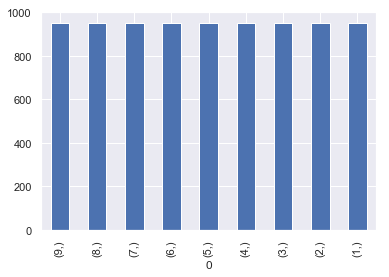

In [65]:
# Distribuição após o smote (grafico de barras)
pd.DataFrame(trainL_Y).value_counts().plot(kind='bar')

## Análise preditiva dados treino

In [66]:
def classifiersAlgorithmsEnsembleTTS(X_train, Y_train, X_test, Y_test):

    # Preparando a lista de modelos
    modelos = []
    
    # Modelo RandomForestClassifier
    modelos.append(('RF', RandomForestClassifier()))
     # Modelo ExtraTreesClassifier
    modelos.append(('ETC', ExtraTreesClassifier()))
    # Modelo ExtremeGradientBoostingClassifier
    modelos.append(('XGBC',XGBClassifier(verbosity = 0)))
    # Modelo BaggingClassifier
    modelos.append(('BC', BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=100)))
    
    
    # Modelo Voting Classifier
    # coloco todos os modelos criados em uma lista para usar no algoritmo VotingClassifier
    estimators = []
    estimators.append(('KNN', KNeighborsClassifier()))
    estimators.append(('nn', MLPClassifier()))
    estimators.append(('NB', GaussianNB()))
    estimators.append(('LR', LogisticRegression()))
    estimators.append(('RF', RandomForestClassifier()))
    estimators.append(('ETC',ExtraTreesClassifier()))

    # Crio o modelo
    modelos.append(('VC', VotingClassifier(estimators=estimators)))
    
    # Modelo com o StackingClassifier
    modelos.append(('SC',StackingClassifier(estimators=estimators)))

  
    # Avaliando cada modelo em um loop
    resultados = []
    nomes = []
    
    for nome, modelo in modelos:
        # Treino o modelo
        modelo.fit(X_train, Y_train)
        # Faço as Previsões de teste
        previsao = modelo.predict(X_test)
        # Accuracy do modelo
        results = accuracy_score(Y_test, previsao)
        resultados.append(results)
        nomes.append(nome)
        print(f'{nome}:  {results:.4f} - Accuracy \n')
            
        # Avaliando Recall com o classification Report
        print( classification_report(Y_test, previsao))
        
        # Matriz de confusão do modelo
        print(pd.crosstab(Y_test, previsao, rownames=['Real'], colnames=['Previsto'], margins=True))
        print('\n')

In [67]:
def classifiersKeras(X, Y, input_shape ):

    # Cria o objeto do tipo sequência
    modelo = keras.models.Sequential()

    # Camada para receber os dados de entrada
    modelo.add(keras.layers.Flatten(input_shape = [input_shape]))

    # Primeira camada oculta com ativação relu
    modelo.add(keras.layers.Dense(300, activation = "relu"))

    # Segunda camada oculta com ativação relu
    modelo.add(keras.layers.Dense(200, activation = "relu"))

    # Terceira camada oculta com ativação relu
    modelo.add(keras.layers.Dense(100, activation = "relu"))

    # Camada de saída com ativação softmax
    # Teremos uma probabilidade prevista para cada classe
    modelo.add(keras.layers.Dense(20, activation = "sigmoid"))
    
    # Compilo o modelo
    modelo.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Faço a divisão dos dados treino e teste
    # Definindo o tamanho das amostras
    teste_size = 0.20

    # Divisão dos dados 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = teste_size)

    
    # Treinamento
    trainModel = modelo.fit(X_train, 
                     Y_train, 
                     epochs = 100, 
                     validation_data = (X_test, Y_test))
    
    # Print da ultima Acuracia para os dados de test.
    _, accuracy = modelo.evaluate(X_test, Y_test)
    print('\n Accuracy Final: %.2f' % (accuracy*100))
    

### Técnica 1 - DataFrame Dummy

In [68]:
# Faço a divisão dos dados treino e teste

# Definindo o tamanho das amostras
teste_size = 0.20

# Divisão dos dados 
X_train, X_test, Y_train, Y_test = train_test_split(trainD_X, trainD_Y, test_size = teste_size)


In [69]:
# Passo os dados para a função de predição para algoritmos Ensemble
classifiersAlgorithmsEnsembleTTS(X_train, Y_train, X_test, Y_test)

RF:  0.8646 - Accuracy 

              precision    recall  f1-score   support

           1       0.85      0.77      0.81       194
           2       0.76      0.89      0.82       184
           3       0.86      0.96      0.91       184
           4       0.85      0.80      0.82       201
           5       0.83      0.85      0.84       199
           6       0.87      0.89      0.88       193
           7       0.82      0.68      0.74       205
           8       0.99      1.00      0.99       171
           9       0.98      0.99      0.99       183

    accuracy                           0.86      1714
   macro avg       0.87      0.87      0.87      1714
weighted avg       0.87      0.86      0.86      1714

Previsto    1    2    3    4    5    6    7    8    9   All
Real                                                       
1         149    0    3   10   19   12    1    0    0   194
2           1  163    0    1    3    2   14    0    0   184
3           0    0  177    6  

In [70]:
# Passo os dados para a função de predição para algoritmo Keras
classifiersKeras(trainD_X,trainD_Y,100)

Epoch 1/100
215/215 [==============================] - 4s 13ms/step - loss: 1.8782 - accuracy: 0.3967 - val_loss: 1.0094 - val_accuracy: 0.6254
Epoch 2/100
215/215 [==============================] - 2s 8ms/step - loss: 0.9051 - accuracy: 0.6569 - val_loss: 0.8575 - val_accuracy: 0.6809
Epoch 3/100
215/215 [==============================] - 2s 8ms/step - loss: 0.8084 - accuracy: 0.6868 - val_loss: 0.8018 - val_accuracy: 0.6949
Epoch 4/100
215/215 [==============================] - 2s 8ms/step - loss: 0.7248 - accuracy: 0.7304 - val_loss: 0.7402 - val_accuracy: 0.7188
Epoch 5/100
215/215 [==============================] - 2s 8ms/step - loss: 0.6734 - accuracy: 0.7357 - val_loss: 0.7181 - val_accuracy: 0.7240
Epoch 6/100
215/215 [==============================] - 2s 8ms/step - loss: 0.6324 - accuracy: 0.7594 - val_loss: 0.7195 - val_accuracy: 0.7153
Epoch 7/100
215/215 [==============================] - 2s 8ms/step - loss: 0.6141 - accuracy: 0.7622 - val_loss: 0.6666 - val_accuracy: 0.750

Epoch 58/100
215/215 [==============================] - 2s 7ms/step - loss: 0.2328 - accuracy: 0.9082 - val_loss: 0.5343 - val_accuracy: 0.8454
Epoch 59/100
215/215 [==============================] - 2s 7ms/step - loss: 0.2250 - accuracy: 0.9082 - val_loss: 0.5376 - val_accuracy: 0.8454
Epoch 60/100
215/215 [==============================] - 2s 7ms/step - loss: 0.2324 - accuracy: 0.9036 - val_loss: 0.5395 - val_accuracy: 0.8460
Epoch 61/100
215/215 [==============================] - 2s 8ms/step - loss: 0.2513 - accuracy: 0.9013 - val_loss: 0.5587 - val_accuracy: 0.8477
Epoch 62/100
215/215 [==============================] - 2s 7ms/step - loss: 0.2413 - accuracy: 0.8994 - val_loss: 0.5503 - val_accuracy: 0.8384
Epoch 63/100
215/215 [==============================] - 2s 7ms/step - loss: 0.2324 - accuracy: 0.9018 - val_loss: 0.5311 - val_accuracy: 0.8506
Epoch 64/100
215/215 [==============================] - 2s 7ms/step - loss: 0.2180 - accuracy: 0.9114 - val_loss: 0.5479 - val_accuracy:

### Técnica 2 - DataFrame LabelEncoder

In [71]:
# Faço a divisão dos dados treino e teste

# Definindo o tamanho das amostras
teste_size = 0.20

# Divisão dos dados 
X_train, X_test, Y_train, Y_test = train_test_split(trainL_X, trainL_Y, test_size = teste_size)

In [72]:
# Passo os dados para a função de predição para algoritmos Ensemble
classifiersAlgorithmsEnsembleTTS(X_train, Y_train, X_test, Y_test)

RF:  0.8267 - Accuracy 

              precision    recall  f1-score   support

           1       0.63      0.73      0.68       186
           2       0.80      0.80      0.80       194
           3       0.87      0.92      0.89       204
           4       0.74      0.70      0.72       168
           5       0.77      0.70      0.73       192
           6       0.90      0.86      0.88       182
           7       0.73      0.69      0.71       180
           8       0.98      1.00      0.99       204
           9       1.00      0.99      0.99       204

    accuracy                           0.83      1714
   macro avg       0.82      0.82      0.82      1714
weighted avg       0.83      0.83      0.83      1714

Previsto    1    2    3    4    5    6    7    8    9   All
Real                                                       
1         135    1    1   24   15    5    5    0    0   186
2           6  155    2    1    5    1   24    0    0   194
3           3    0  188    5  

In [73]:
# Passo os dados para a função de predição para algoritmo Keras
classifiersKeras(trainL_X,trainL_Y,62)

Epoch 1/100
215/215 [==============================] - 2s 9ms/step - loss: 20.9573 - accuracy: 0.1121 - val_loss: 5.4729 - val_accuracy: 0.1161
Epoch 2/100
215/215 [==============================] - 1s 7ms/step - loss: 4.9558 - accuracy: 0.1514 - val_loss: 3.2635 - val_accuracy: 0.1523
Epoch 3/100
215/215 [==============================] - 2s 7ms/step - loss: 3.3386 - accuracy: 0.1848 - val_loss: 2.6705 - val_accuracy: 0.1517
Epoch 4/100
215/215 [==============================] - 2s 7ms/step - loss: 2.5946 - accuracy: 0.2171 - val_loss: 3.7556 - val_accuracy: 0.1698
Epoch 5/100
215/215 [==============================] - 2s 7ms/step - loss: 2.6519 - accuracy: 0.2277 - val_loss: 2.0752 - val_accuracy: 0.2170
Epoch 6/100
215/215 [==============================] - 2s 7ms/step - loss: 2.2383 - accuracy: 0.2616 - val_loss: 2.3463 - val_accuracy: 0.2194
Epoch 7/100
215/215 [==============================] - 2s 7ms/step - loss: 2.2544 - accuracy: 0.2730 - val_loss: 2.2900 - val_accuracy: 0.243

Epoch 58/100
215/215 [==============================] - 1s 7ms/step - loss: 1.0501 - accuracy: 0.5956 - val_loss: 1.2030 - val_accuracy: 0.5735
Epoch 59/100
215/215 [==============================] - 1s 7ms/step - loss: 1.0225 - accuracy: 0.6069 - val_loss: 1.0673 - val_accuracy: 0.6167
Epoch 60/100
215/215 [==============================] - 1s 7ms/step - loss: 1.0636 - accuracy: 0.5936 - val_loss: 1.2314 - val_accuracy: 0.5432
Epoch 61/100
215/215 [==============================] - 2s 8ms/step - loss: 1.0773 - accuracy: 0.5938 - val_loss: 1.2756 - val_accuracy: 0.5158
Epoch 62/100
215/215 [==============================] - 2s 7ms/step - loss: 1.0375 - accuracy: 0.5925 - val_loss: 1.1415 - val_accuracy: 0.5863
Epoch 63/100
215/215 [==============================] - 1s 7ms/step - loss: 1.0327 - accuracy: 0.6053 - val_loss: 1.3317 - val_accuracy: 0.5478
Epoch 64/100
215/215 [==============================] - 2s 7ms/step - loss: 1.0300 - accuracy: 0.6028 - val_loss: 1.0846 - val_accuracy:

Para Técnica – 1 Dummy tivemos uma boa performance tanto nos algoritmos ensemble quanto no keras, já para a Técnica – 2 LabelEncoder, o aproveitamento foi abaixo, iremos continuar com a Tecnica – 1 e com o algoritmo do keras, tentarei Otimizar para tentar melhorar a performance para criar o modelo final e então realizar a previsão nos dada novos. 

In [196]:
# Tentarei melhorar a performance do modelo com o Keras.
# Crio a função para o modelo
def classifiersKerasTuner(hp):

    # Cria o objeto do tipo sequência
    modelo = keras.models.Sequential()

    # Camada para receber os dados de entrada
    modelo.add(keras.layers.Flatten(input_shape = [100]))
    
    # Ajuste o número de unidades nas camadas Densa
    hp_units = hp.Int('units', min_value=32, max_value=512, step=10)

    # Primeira camada oculta com ativação relu
    modelo.add(keras.layers.Dense(units=hp_units, activation = "relu"))

    # Segunda camada oculta com ativação relu
    modelo.add(keras.layers.Dense(units=hp_units, activation = "relu"))

    # Terceira camada oculta com ativação relu
    modelo.add(keras.layers.Dense(units=hp_units, activation = "relu"))
    
    # Quarta camada oculta com ativação relu
    modelo.add(keras.layers.Dense(units=hp_units, activation = "relu"))
        
    # Ajuste a taxa de aprendizagem para o otimizador
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4,1e-5])
    
    # Camada de saída com ativação softmax
    # Teremos uma probabilidade prevista para cada classe
    modelo.add(keras.layers.Dense(20, activation = "sigmoid"))
    
    # Compilo o modelo
    modelo.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    
    return modelo
    
    

In [197]:
# Rodo a função para criar o modelo para pesquisar os melhores parâmetros.
tuner = kt.Hyperband(classifiersKerasTuner,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=4,
                     directory='/Dados/',
                     project_name='kt/')

In [198]:
# Aplico o algoritmo nos mesmos dados de treino para que ele possa mostrar os melhores parâmetros.

# Faço a divisão dos dados treino e teste
# Definindo o tamanho das amostras
teste_size = 0.20

# Divisão dos dados 
X_train, X_test, Y_train, Y_test = train_test_split(trainD_X, trainD_Y, test_size = teste_size)

    
# Treinamento
trainModel = tuner.search(X_train, 
            Y_train, 
            epochs = 100, 
            validation_data = (X_test, Y_test))
    


Trial 161 Complete [00h 05m 05s]
val_accuracy: 0.7292882204055786

Best val_accuracy So Far: 0.845974326133728
Total elapsed time: 01h 21m 52s
INFO:tensorflow:Oracle triggered exit


In [199]:
# Pego os melhores paramentros 
best_param = tuner.get_best_hyperparameters(num_trials=1)[0]

# Crio o modelo funal com os melhores parametros
modelo_keras_final = tuner.hypermodel.build(best_param)

In [200]:
# Imprimo o summary do modelo. 
modelo_keras_final.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 482)               48682     
_________________________________________________________________
dense_1 (Dense)              (None, 482)               232806    
_________________________________________________________________
dense_2 (Dense)              (None, 482)               232806    
_________________________________________________________________
dense_3 (Dense)              (None, 482)               232806    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                9660      
Total params: 756,760
Trainable params: 756,760
Non-trainable params: 0
__________________________________________________

In [201]:
# Aplico o modelo final nos dados de treino.

# Faço a divisão dos dados treino e teste
# Definindo o tamanho das amostras
teste_size = 0.20

# Divisão dos dados 
X_train, X_test, Y_train, Y_test = train_test_split(trainD_X, trainD_Y, test_size = teste_size)

    
# Treinamento
trainModel = modelo_keras_final.fit(X_train, 
            Y_train, 
            epochs = 100, 
            validation_data = (X_test, Y_test))
    

Epoch 1/100
215/215 [==============================] - 4s 15ms/step - loss: 1.6157 - accuracy: 0.4284 - val_loss: 0.9518 - val_accuracy: 0.6634
Epoch 2/100
215/215 [==============================] - 3s 13ms/step - loss: 0.8408 - accuracy: 0.6824 - val_loss: 0.8500 - val_accuracy: 0.6418
Epoch 3/100
215/215 [==============================] - 3s 12ms/step - loss: 0.7356 - accuracy: 0.7144 - val_loss: 0.7634 - val_accuracy: 0.7025
Epoch 4/100
215/215 [==============================] - 3s 14ms/step - loss: 0.6728 - accuracy: 0.7476 - val_loss: 0.7117 - val_accuracy: 0.7270
Epoch 5/100
215/215 [==============================] - 3s 14ms/step - loss: 0.5993 - accuracy: 0.7654 - val_loss: 0.6642 - val_accuracy: 0.7445
Epoch 6/100
215/215 [==============================] - 3s 14ms/step - loss: 0.5279 - accuracy: 0.7997 - val_loss: 0.6517 - val_accuracy: 0.7503
Epoch 7/100
215/215 [==============================] - 3s 15ms/step - loss: 0.5330 - accuracy: 0.7924 - val_loss: 0.5897 - val_accuracy:

In [202]:
# Jogo em uma variável a época que o modelo teve a melhor acurácia.
val_acc_per_epoch = trainModel.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

# Crio o modelo funal com os melhores parametros e melhor epoca.
modelo_keras_final = tuner.hypermodel.build(best_param)

# Aplico o modelo final nos dados de treino.

# Faço a divisão dos dados treino e teste
# Definindo o tamanho das amostras
teste_size = 0.20

# Divisão dos dados 
X_train, X_test, Y_train, Y_test = train_test_split(trainD_X, trainD_Y, test_size = teste_size)

    
# Treinamento
trainModel = modelo_keras_final.fit(X_train, 
            Y_train, 
            epochs = best_epoch, 
            validation_data = (X_test, Y_test))

Epoch 1/79
215/215 [==============================] - 4s 15ms/step - loss: 1.6208 - accuracy: 0.4461 - val_loss: 0.9714 - val_accuracy: 0.6377
Epoch 2/79
215/215 [==============================] - 3s 15ms/step - loss: 0.8555 - accuracy: 0.6757 - val_loss: 0.8146 - val_accuracy: 0.7112
Epoch 3/79
215/215 [==============================] - 3s 15ms/step - loss: 0.7386 - accuracy: 0.7174 - val_loss: 0.7310 - val_accuracy: 0.7229
Epoch 4/79
215/215 [==============================] - 3s 14ms/step - loss: 0.6278 - accuracy: 0.7594 - val_loss: 0.6950 - val_accuracy: 0.7398
Epoch 5/79
215/215 [==============================] - 3s 14ms/step - loss: 0.5990 - accuracy: 0.7606 - val_loss: 0.6621 - val_accuracy: 0.7445
Epoch 6/79
215/215 [==============================] - 3s 15ms/step - loss: 0.5475 - accuracy: 0.7809 - val_loss: 0.6180 - val_accuracy: 0.7701
Epoch 7/79
215/215 [==============================] - 3s 14ms/step - loss: 0.4900 - accuracy: 0.8081 - val_loss: 0.5976 - val_accuracy: 0.7614

Epoch 58/79
215/215 [==============================] - 3s 14ms/step - loss: 0.1976 - accuracy: 0.9190 - val_loss: 0.7294 - val_accuracy: 0.8378
Epoch 59/79
215/215 [==============================] - 3s 14ms/step - loss: 0.2239 - accuracy: 0.9160 - val_loss: 0.7219 - val_accuracy: 0.8337
Epoch 60/79
215/215 [==============================] - 3s 14ms/step - loss: 0.2083 - accuracy: 0.9111 - val_loss: 0.7099 - val_accuracy: 0.8407
Epoch 61/79
215/215 [==============================] - 3s 14ms/step - loss: 0.2108 - accuracy: 0.9139 - val_loss: 0.7008 - val_accuracy: 0.8431
Epoch 62/79
215/215 [==============================] - 3s 14ms/step - loss: 0.1992 - accuracy: 0.9157 - val_loss: 0.7445 - val_accuracy: 0.8355
Epoch 63/79
215/215 [==============================] - 3s 14ms/step - loss: 0.2122 - accuracy: 0.9139 - val_loss: 0.7323 - val_accuracy: 0.8343
Epoch 64/79
215/215 [==============================] - 3s 13ms/step - loss: 0.2065 - accuracy: 0.9144 - val_loss: 0.6834 - val_accuracy:

Mesmo com o processo de otimização, tivemos apenas uma pequena melhora em alguns momentos do treinamento, mas mantendo o padrão que foi visto no primeiro que foi 92% de acurácia em dados de treino e 86% nos dados que o modelo não havia visto. Considerando que temos muito pouco dados para treinar levando em conta que modelos como esse são baseados no conceito de BigData, ou seja, muitos dados, o modelo atingiu provavelmente seu limite, com 86% de acurácia nos dados não visto no treinamento, possivelmente se tivéssemos mais dados ele conseguiria melhores resultados ainda. Dentro desse panorama vou considerar esse modelo com 86% de acurácia para o projeto final nos dados novos. 

In [205]:
# Salvo o modelo com os melhores parametros e os pesos. 

# Serializar modelo para JSON
model_json = modelo_keras_final.to_json()
with open("Model/modelo_keras_final.json", "w") as json_file:
    json_file.write(model_json)
# Serializar pesos para HDF5
modelo_keras_final.save_weights("Model/modelo_keras_final.h5")
print("Modelo salvo")

Modelo salvo


In [207]:
#Carregamento do modelo ( Descomente para carregar )
'''
# Carregado o modelo e pelo arquivo json criado.
json_file = open('Model/modelo_keras_final.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
modelo_keras_final = model_from_json(loaded_model_json)
# load weights into new model
modelo_keras_final.load_weights("Model/modelo_keras_final.h5")
print("Modelo carregado")
'''

Modelo carregad


## Analise preditiva nos dados novos. 

In [318]:
# Carregos os dados. 
df_test = pd.read_csv('Dados/test_variants') 
test_text = pd.read_csv('Dados/test_text', sep="\|\|",names=["ID","Text"],skiprows=1)

In [280]:
df_test.shape

(5668, 3)

In [213]:
test_text.shape

(5668, 2)

### Tratamento dos dados

Aplicarei os mesmo tratamentos feito para os dados de teste para a técnica – 1 Dummy, assim como o tratamento dos textos, deixando esse DataFrame no mesmo formato que o de treino passado para os modelos. 

In [214]:
# Faço uma copia do df_train para usar no tratamento
df_test_dummy = df_test.copy()

# Crio as variáveis Dummy
gene_dummies = pd.get_dummies(df_test_dummy['Gene'])
variation_dummies = pd.get_dummies(df_test_dummy['Variation'])

# Uso o concat para trazer as dummies para o DataFrane
variation_dummies = pd.concat([df_test_dummy,gene_dummies,variation_dummies],axis=1)

# Retiro as variáveis categoricas em string.
variation_dummies.drop(['Gene','Variation'], axis=1, inplace=True)

# Imprimo o resultado em 5 primeiras linhas.
variation_dummies.head()

,ID,A4GALT,AAAS,AANAT,AARS,ABCA1,ABCA12,ABCA3,ABCA4,ABCB11,...,null373C,null380R,null399R,null420W,null423L,null462G,null483L,null496R,null522S,null654G
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [215]:
# Faço o pré processamento gerando um DataFrame novo ja com o texto tratado. 
test_text_clear = text_preprocess(test_text)

# Imprimo as 5 primeiras linhas
test_text_clear.head(5)

,ID,Text
0,0,mutat result myeloprolif phenotyp includ eryth...
1,1,abstract larg tumor suppressor lat serin threo...
2,2,vascular endotheli growth factor receptor vegf...
3,3,inflammatori myofibroblast tumor imt neoplasm ...
4,4,abstract retinoblastoma pediatr retin tumor in...


In [295]:
# Faço a vetorização usando os dados de treino no fit, para ter o mesmo padrão quando transformar as de teste.

#Faco uma copia do DataFrame limpo.
text2 = test_text_clear.copy()
       
# Crio o algoritmo para a vetorização com no max 2000 variáveis.
vectorizer = TfidfVectorizer(stop_words = 'english',max_features = 2000)
    
# Rodo ja criando uma lista e convertendo para array
vectorizer.fit(train_text_clear['Text'])

# Faço a transformação nos textos dos dados novos baseando nos de treino.
textVec = list(vectorizer.transform(text2['Text'].values).toarray())
   
# Converto o array em um DataFrame do pandas. 
textVec = pd.DataFrame(textVec)


In [296]:
# Imprimo as 10 primeiras linhas
textVec.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.0,0.000000,0.000000,0.000000,0.002836,0.045617,0.007711,0.004612,0.004230,...,0.000000,0.0,0.000000,0.000000,0.013444,0.000000,0.000000,0.0,0.000000,0.000000
1,0.028489,0.0,0.000000,0.000000,0.000000,0.010169,0.016355,0.013823,0.008268,0.007584,...,0.000000,0.0,0.094742,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.003459,0.0,0.003955,0.000000,0.000000,0.001852,0.001986,0.000000,0.006024,0.000000,...,0.064007,0.0,0.000000,0.004601,0.004390,0.000000,0.000000,0.0,0.000000,0.000000
3,0.000000,0.0,0.000000,0.003136,0.000000,0.004839,0.000000,0.000000,0.000000,0.021654,...,0.000000,0.0,0.000000,0.000000,0.020072,0.004314,0.004245,0.0,0.005948,0.000000
4,0.018505,0.0,0.000000,0.000000,0.000000,0.008256,0.003541,0.004489,0.000000,0.009852,...,0.006340,0.0,0.000000,0.000000,0.005870,0.002944,0.000000,0.0,0.012177,0.000000
5,0.011480,0.0,0.000000,0.000000,0.011973,0.000000,0.000000,0.025066,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.007284,0.000000,0.000000,0.0,0.000000,0.000000
6,0.000000,0.0,0.000000,0.003181,0.000000,0.004910,0.002632,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.004377,0.000000,0.0,0.000000,0.000000
7,0.003363,0.0,0.003845,0.000000,0.003508,0.003601,0.000000,0.002448,0.011712,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.054275
8,0.000000,0.0,0.000000,0.009478,0.007123,0.003657,0.015683,0.009942,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.013000,0.006519,0.000000,0.0,0.000000,0.000000
9,0.000000,0.0,0.007501,0.002277,0.003422,0.001757,0.000000,0.000000,0.000000,0.000000,...,0.003373,0.0,0.000000,0.000000,0.016654,0.000000,0.000000,0.0,0.000000,0.000000


In [297]:
# Crio um novo DataFrame junto as variaveis vetorizadas ao DataFrame com o ID
testvec = test_text_clear.reset_index().join(textVec)

# Recoloco o index que foi resetado para o join anterior
testvec = testvec.set_index('index')

# Removo a variável Text que não será mais necessária.
testvec = testvec.drop(columns =['Text'])

# Ja verifico se gerou algum valor nulo. 
testvec[testvec.isnull().any(axis=1,)]

,ID,0,1,2,3,4,5,6,7,8,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
index,,,,,,,,,,,,,,,,,,,,,


In [298]:
# Faço o Join pela variável ID
test = pd.merge(variation_dummies,testvec,how='left', on='ID')
test.head(10)


,ID,A4GALT,AAAS,AANAT,AARS,ABCA1,ABCA12,ABCA3,ABCA4,ABCB11,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.013444,0.000000,0.000000,0.0,0.000000,0.000000
1,1,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.094742,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,2,0,0,0,0,0,0,0,0,0,...,0.064007,0.0,0.000000,0.004601,0.004390,0.000000,0.000000,0.0,0.000000,0.000000
3,3,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.020072,0.004314,0.004245,0.0,0.005948,0.000000
4,4,0,0,0,0,0,0,0,0,0,...,0.006340,0.0,0.000000,0.000000,0.005870,0.002944,0.000000,0.0,0.012177,0.000000
5,5,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.007284,0.000000,0.000000,0.0,0.000000,0.000000
6,6,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.004377,0.000000,0.0,0.000000,0.000000
7,7,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.054275
8,8,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.013000,0.006519,0.000000,0.0,0.000000,0.000000
9,9,0,0,0,0,0,0,0,0,0,...,0.003373,0.0,0.000000,0.000000,0.016654,0.000000,0.000000,0.0,0.000000,0.000000


In [299]:
# Verifico que gerou um valor nulo, isso se deu pois nos dados com as descrições das evidencias o ID 1623 não existe,então vou remove-lo, ja que não é possivel ter essa informação.  
test[test.isnull().any(axis=1,)]

,ID,A4GALT,AAAS,AANAT,AARS,ABCA1,ABCA12,ABCA3,ABCA4,ABCB11,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
1623,1623,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [300]:
# Realizo o drop da linha
test.dropna(axis=0, inplace=True)

# Verifico novamente.  
test[test.isnull().any(axis=1,)]


,ID,A4GALT,AAAS,AANAT,AARS,ABCA1,ABCA12,ABCA3,ABCA4,ABCB11,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999


In [301]:
test.shape

(5667, 9026)

In [302]:
# Salvo DataFrame para a técnica 2 pronto para não precisa reprocessar tudo novamente se necessário.
test.to_csv('Dados/test.csv',encoding="utf-8", index=None)

In [328]:
# Carrego os dados caso for iniciar a partir daqui. Descomente a linha. 
#test = pd.read_csv('Dados/test.csv',encoding="utf-8")

In [331]:
# Agora para finalizar ire realizar o PCA das variáveis diminuindo para 100. 

# Removo a variável ID e a Class deixando apenas as variáveis preditoras.
Xtest = test.drop(columns =['ID'])

# Crio o PCA para reduzir a dimensionalidade para 100 variáveis
pca = PCA(n_components=100)
pca_fit = pca.fit(Xtest)
X = pca_fit.transform(Xtest)

In [304]:
# Shape apos o PCA
X.shape

(5667, 100)

In [305]:
# Dados apos o PCA
X

array([[-0.16144104,  0.37151131, -0.07644963, ..., -0.00043708,
         0.01530729, -0.03070407],
       [ 0.01619626, -0.0887654 , -0.10643132, ..., -0.00692019,
        -0.00667276, -0.00231756],
       [-0.03153525,  0.00177547, -0.13875074, ..., -0.04218995,
        -0.04038945,  0.06780306],
       ...,
       [-0.06948917,  0.13154605,  0.03018906, ..., -0.02138092,
        -0.00438444,  0.00545006],
       [-0.03488481,  0.05036968, -0.07281315, ...,  0.02565394,
        -0.00231663, -0.03221029],
       [-0.01997281, -0.04348404,  0.17056185, ..., -0.10049759,
        -0.00339889, -0.05245427]])

In [306]:
# Faço as previsões 
Y = modelo_keras_final.predict_classes(X)

In [307]:
#Shape das previsões
Y.shape

(5667,)

In [308]:
# primeiros valores das previsoes
Y

array([6, 8, 2, ..., 5, 4, 6], dtype=int64)

In [309]:
# Distribuição das previsões 
Y = pd.Series(Y)
Y.value_counts()

7    1128
2    1001
4     761
6     703
5     702
1     464
8     439
3     372
9      97
dtype: int64

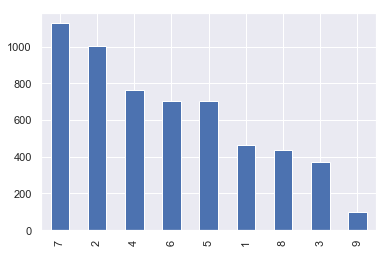

In [311]:
# Distribuição das previsões ( Grafico de barras)
Y.value_counts().plot(kind='bar')

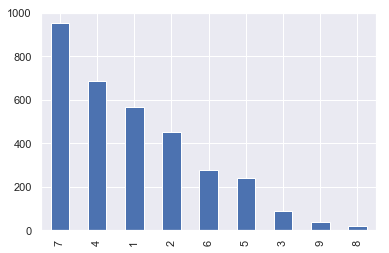

In [238]:
# Distribuição da target dos dados de treino ( Grafico de barras)
df_train['Class'].value_counts().plot(kind='bar')

Podemos ver que tanto nos labels de treino quanto nas previsões temo como maior quantidade a classe 7 

In [323]:
# Adiciono as classes previstas ao DataFrame.

# Antes de adcionar tenho que fazer o drop da linha que apaguei nos dados antes da previsão.
df_test = df_test.drop(df_test.index[1623])

# Adiciono as previsões
df_test['Class'] = Y.values

# Coloco o ID como index
df_test = df_test.set_index('ID')

In [326]:
# Imprimo as primeiras lnhas
df_test.head()

,Gene,Variation,Class
ID,,,
0,ACSL4,R570S,6
1,NAGLU,P521L,8
2,PAH,L333F,2
3,ING1,A148D,6
4,TMEM216,G77A,4


In [327]:
# Imprimo as Ultimas linhas
df_test.tail()

,Gene,Variation,Class
ID,,,
5663,SLC46A1,R113S,8
5664,FOXC1,L130F,2
5665,GSS,R267W,5
5666,CTSK,G79E,4
5667,DFNB59,T54I,6


## Considerações Finais


Temos agora os dados novos com seus respectivos labels previsto pelo modelo, para novas previsões e só carregar o algoritmo salvo já treinado e realizar as previsões.

Nesse projeto como visto usei o modelo com o Keras, porem como fizemos no treinamento o teste com vários modelos e tivemos também resultados satisfatórios poderíamos ter feito as previsões baseados em outros modelos, porem para esse projeto optei para o modelo final com o Keras. 

## Obrigado! Entre em contato comigo acessando meu portifolio (https://campos1989.github.io/) no menu contato!